<a href="https://colab.research.google.com/github/makagan/SSI_Projects/blob/main/jet_notebooks/6.JetTaggingGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jet Tagging with ParticleNet

In this tutorial we will implement a graph neural network for jet tagging. Jet tagging is a task of a jet classfication.

We will represent each jet as a point cloud (or a "particle cloud") which consists of unordered set of jet's consistuent particles. Such a particle cloud representation of jets is efficient in incorporating raw information of jets and also explicitly respects the permutation symmetry. Based on the particle cloud representation, we will implement ParticleNet - a customized neural network architecture that uses Dynamic Graph Convolutional Neural Network : https://arxiv.org/abs/1902.08570.

The task of jet tagging can be translated to graph classifcation task aiming to distinguish jets originating from quarks, gluons, W or Z bosons, or top quarks.

We will use PyTorch Geometric to build ParticleNet.

Before you start, choose GPU as a hardware accelerator for this notebook. To do this first go to Edit -> Notebook Settings -> Choose GPU as a hardware accelerator.


In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
import matplotlib.pyplot as plt
%matplotlib inline
# Numpy, h5py, etc
import numpy as np
import h5py

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Set up a GPU for the training and check how much memory is available.

In [2]:
def print_device_usage(device):
  tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
  reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
  allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
  free_memory = reserved_memory-allocated_memory  # free inside reserved
  print('Total memory in Gb: %.2f'%tot_memory)
  print('Reserved memory in Gb: %.2f'%reserved_memory)
  print('Allocated memory in Gb: %.2f'%allocated_memory)
  print('Free memory in Gb: %.2f'%free_memory)


# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)

device :  cuda:0
Total memory in Gb: 14.75
Reserved memory in Gb: 0.00
Allocated memory in Gb: 0.00
Free memory in Gb: 0.00


# Dataset exploration

First, let's download the jet-tagging dataset

In [3]:
! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  12.3M      0 --:--:--  0:00:27 --:--:-- 16.3M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [4]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


*   'jetImage' ,' jetImageECAL' and 'jetImageHCAL' contains the image representation of the jets  . We will not use them today but build our point cloud from the other information.
*   'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored. This is the dataset we will consider in this notebook.
*   'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
*   'jets' is the list of jets with the high-level jet features stored. We will only use jet ID from it, indecies [-6:-1]
*   'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'. These quantities are build using physics knowledge and correspond to high-level infromation and features per graph (as opposed to per node)

The first 100 highest transverse momentum $p_T$ particles are considered for each jet.



In [5]:
target = np.array([])
jetList = np.array([])
features_names = dict()
datafiles = os.listdir(data_dir)
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[:,[np.argmax(f['jetFeatureNames'][:]==b'j_mass'),-6,-5,-4,-3,-2]]) # jet mass and class labels
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target = np.concatenate([target, target_file], axis=0) if target.size else target_file
    del jetList_file, target_file
    #save particles/nodes features names and their indicies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

Appending jetImage_7_100p_60000_70000.h5
Appending jetImage_7_100p_50000_60000.h5
Appending jetImage_7_100p_40000_50000.h5
Appending jetImage_7_100p_0_10000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_80000_90000.h5
Appending jetImage_7_100p_70000_80000.h5
Appending jetImage_7_100p_10000_20000.h5


The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
*  [1, 0, 0, 0, 0] for gluons
*  [0, 1, 0, 0, 0] for quarks
*  [0, 0, 1, 0, 0] for W
*  [0, 0, 0, 1, 0] for Z
*  [0, 0, 0, 0, 1] for top quarks

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems). These labels are the 'target' for our classification tasks. Let's convert it back to single-column encoding :


In [6]:
print("Target for the first five entries in the dataset - mass and one-hot encoded labels:")
print(target[:5,:])
print("Labels for the first five entries in the dataset, one-hot encoded:")
for i in range(5):
    print(target[i,1:])
target = np.stack((target[:,0], np.argmax(target[:,1:], axis=1)), axis=1)
print("Labels for the first five entries in the dataset, single column encoded:")
for i in range(0,5):
    print(target[i,1])

Target for the first five entries in the dataset - mass and one-hot encoded labels:
[[187.22622681   0.           0.           0.           0.
    1.        ]
 [ 80.29190826   0.           0.           1.           0.
    0.        ]
 [165.20379639   0.           0.           0.           0.
    1.        ]
 [ 46.41217041   0.           0.           1.           0.
    0.        ]
 [223.79852295   1.           0.           0.           0.
    0.        ]]
Labels for the first five entries in the dataset, one-hot encoded:
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
Labels for the first five entries in the dataset, single column encoded:
4.0
2.0
4.0
2.0
0.0


Now our lables correspond to :
*  0 for gluons
*  1 for quarks
*  2 for W
*  3 for Z
*  4 for top quarks


In [7]:
num_classes = len(np.unique(target[:,1]))
label_names= ["gluon", "quark", "W", "Z", "top"]

Now let's inspect our data. Each jet is a point cloud/graph with 100 particles/nodes, each of which has 16 features. We have a double-index dataset: (jet index, particle index). The list is cut at 100 constituents per jet. If less constituents are present in the jet/point cloud, the dataset is completed filling it with 0s (zero padding). Note : zero-padding is not using during the training, it is only used to store the ragged dataset.



In [8]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (80000, 100, 16)
Target/Labels shape :  (80000, 2)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


We are not interested in all features for now. For now we will only consider the same node features as were considered in the ParticleNet paper: 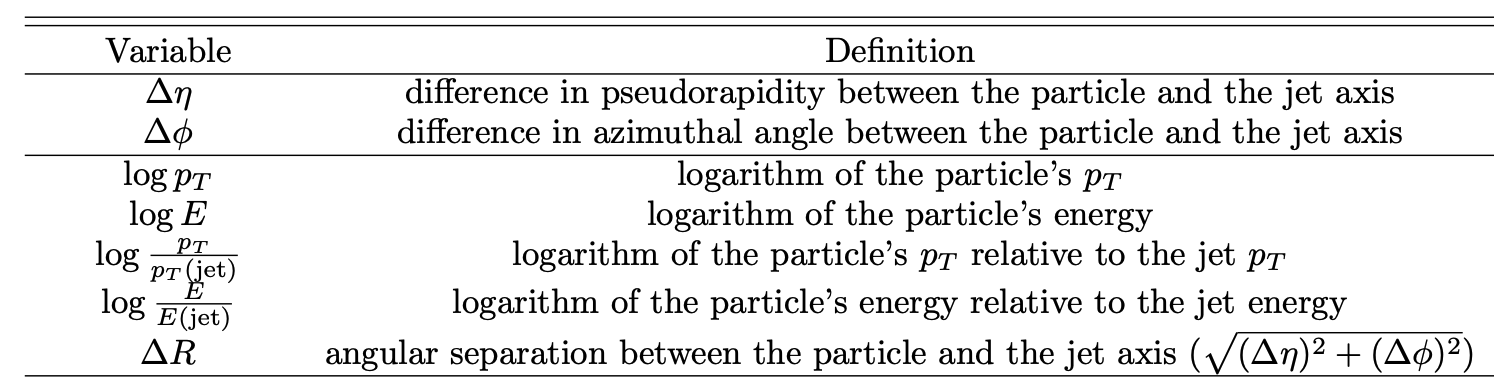

In [9]:
features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
log_feature_indices = [2,3,4,5] # Take logarithm of these features later
features_idx = [features_names[name] for name in features_to_consider]
jetList = jetList[:,:,features_idx]

In [10]:
# Check if the sample is balanced in terms of the number of examples of each type of jet
for idx, jet_type in enumerate(label_names):
    print(jet_type, np.sum(target[:,1]==idx)/len(target[:,1])*100, "%")

gluon 20.03375 %
quark 19.66 %
W 20.125 %
Z 20.0875 %
top 20.09375 %


Now let's plot the disributions of the jets consituents (node features).

In [11]:
#Let's define a helper function to plot the distibutions
def plot_features(feat_idx, input_data, features_to_consider):
    plt.subplots(figsize=(5,5))
    for jet_type_idx in range(len(label_names)):
        data_feature = input_data[:,:,feat_idx]
        data_feature = data_feature[target[:,1] == jet_type_idx]
        # then plot the right quantity for the reduced array (merge all constituents together)
        plt.hist(data_feature[:,feat_idx].flatten(), bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
    #plt.yscale('log', nonposy='clip')
    plt.legend(label_names, fontsize=12, frameon=False)
    plt.xlabel(features_to_consider[feat_idx], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()


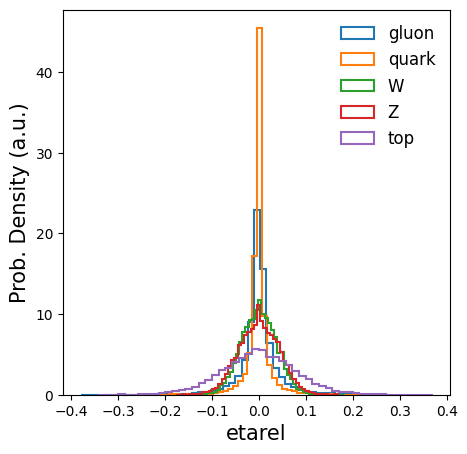

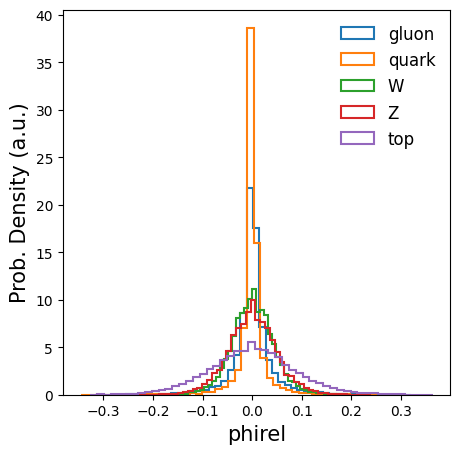

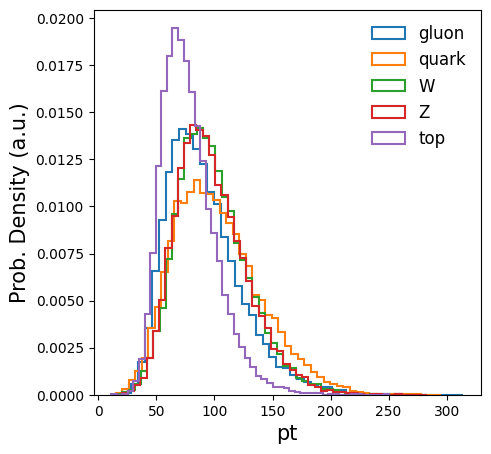

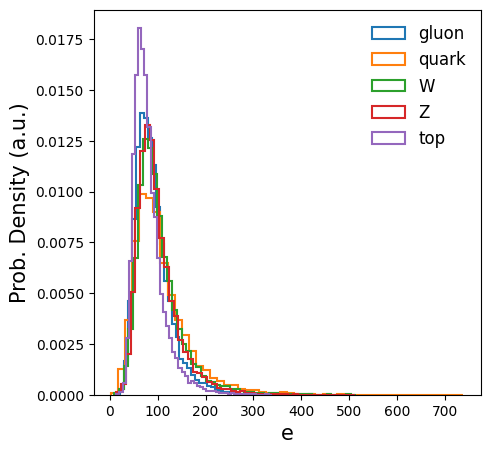

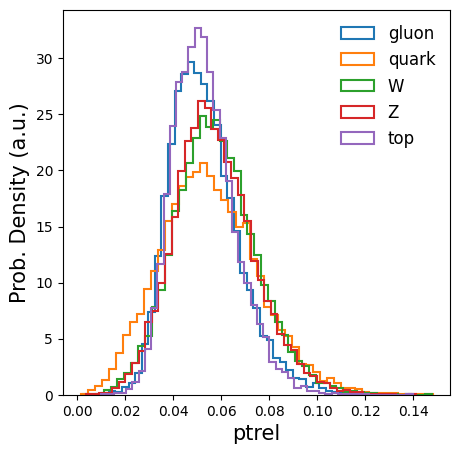

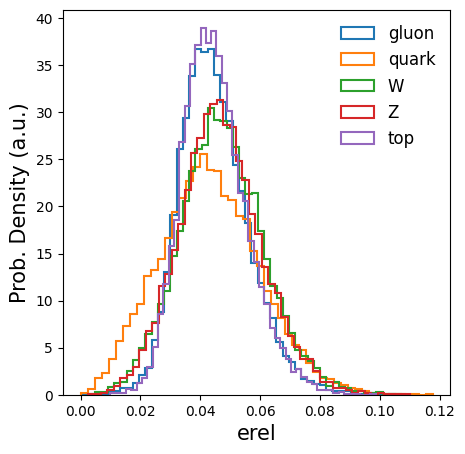

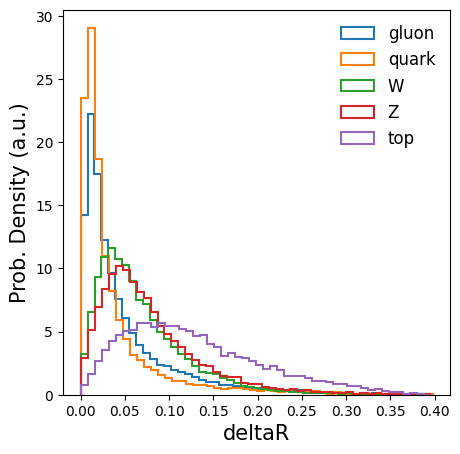

In [12]:
# we now plot all the features
for i in range(len(features_to_consider)):
    plot_features(i, jetList, features_to_consider)


In [13]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_jets = len(jetList) #number of training+validation samples
mask_real = np.where(jetList[0,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
jets_without_zero_padding = []
for i_jet in range(num_jets):
    # remove the zero padded particles
    mask_real = np.where(jetList[i_jet,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
    jets_without_zero_padding.append(jetList[i_jet,mask_real,:].squeeze())
jets_without_zero_padding = np.concatenate(jets_without_zero_padding)
jets_without_zero_padding[:,log_feature_indices] = np.log(jets_without_zero_padding[:,log_feature_indices])
scaler.fit_transform(jets_without_zero_padding)

array([[-0.11386796, -0.59584922,  1.48624641, ...,  1.50342305,
         1.5012342 , -0.58364805],
       [-0.18432394, -0.5351751 ,  1.42230051, ...,  1.43953297,
         1.43898201, -0.62895455],
       [ 1.57359676,  1.51167621,  1.33824619, ...,  1.35555207,
         1.31855265,  1.22642258],
       ...,
       [ 1.94573753,  1.08050946, -1.65828956, ..., -1.64568573,
        -1.75285123,  1.28779137],
       [ 2.9614852 , -0.79092714, -1.82144568, ..., -1.80869934,
        -1.93417503,  2.26287438],
       [ 2.42282202, -0.9087539 , -1.82549927, ..., -1.81274941,
        -1.9419708 ,  1.70931512]])

# Building ParticleNet

The ParticleNet architecture is based on [Dynamic Graph Convolutional Neural Networks](https://dl.acm.org/doi/10.1145/3326362) (DGCNN) which are a special case of GCN where the graph is re-built in the new ${h_i^{(k)}}$ latent space created by the node feature update. A way to build a graph is through the *K-nearest neighbors algorithm*: per each node the Euclidean distance to all the other nodes is calculated and the K closest nodes are chosen to be connected to the target node.

<div>
<img src="https://raw.githubusercontent.com/jngadiub/ML_course_Pavia_23/main/neural-networks/particle-net-arch.png" width="800"/>
</div>

We will use the built in [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.EdgeConv.html) module with the [`knn_graph`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.knn_graph.html#torch_geometric.nn.pool.knn_graph) method implemented in PyG. However, this is not the only way (see optional excercise at the end of the notebook).

In [14]:
from torch import nn
from torch_geometric.nn import EdgeConv, global_mean_pool, DynamicEdgeConv
from torch_cluster import knn_graph
import torch.nn.functional as F


class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size)) #undirected graph
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)


class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=5,
                 k=16, kernel_sizes=[64, 128, 256], fc_sizes=[256], dropout=0.1,
                 aggr='mean'):
        super(ParticleNet, self).__init__()
        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k #for kNN algo
        self.kernel_sizes = kernel_sizes #number of units in the three linear transformation layers in each EdgeConv block
        self.num_edge_convs = len(self.kernel_sizes) #number of stacked EdgeConv blocks

        self.fc_sizes =  fc_sizes #units of the first FC layer after EdgeConv blocks
        self.dropout = dropout

        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes) #inputs include also previous layer output

        #the first EdgeConv block
        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1]))
        self.edge_convs.append(DynamicEdgeConv(self.edge_nets[-1], k=self.k, aggr=aggr))

        #stack other two EdgeConv blocks
        for i in range(1, self.num_edge_convs):
            print("self.num_edge_convs",i)
            # adding kernel sizes because of skip connections
            self.edge_nets.append(
                ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i + 1])
            )
            self.edge_convs.append(DynamicEdgeConv(self.edge_nets[-1], k=self.k, aggr=aggr))

        for i, fc_size in enumerate(fc_sizes):
            if i == 0:
                self.fc_layers.append(nn.Sequential(nn.Linear(self.output_sizes[-1], fc_size)))
            else:
                self.fc_layers.append(nn.Sequential(nn.Linear(self.fc_sizes[i-1], fc_size)))

            if self.dropout >= 0:
                self.fc_layers.append(nn.Dropout(p=self.dropout))

        if len(self.fc_layers) >= 1:
            self.fc_layers.append(nn.Linear(self.fc_sizes[-1], self.num_classes+1))
        else:
            self.fc_layers.append(nn.Linear(self.output_sizes[-1], self.num_classes+1))

    def forward(self, data):
        # input data is an instance of PyG Data()
        x = data.x
        batch = data.batch

        for i in range(self.num_edge_convs):
            x = torch.cat(
                (self.edge_convs[i](x, batch), x), dim=1
            )  # concatenating with original features i.e. skip connection

        x = global_mean_pool(x, batch) # this runs scatter under the hood
        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        return x

In [15]:
from torch_geometric.data import Data

jet_dataset = []
for i_jet in range(num_jets):
    # remove the zero padded particles
    mask_real = np.where(jetList[i_jet,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
    num_nodes = len(mask_real[0])
    jets_without_zero_padding = jetList[i_jet,mask_real,:].squeeze()
    jets_without_zero_padding[:,log_feature_indices] = np.log(jets_without_zero_padding[:,log_feature_indices])
    d = Data(x=torch.tensor(scaler.transform(jets_without_zero_padding), dtype=torch.float),
             y=torch.tensor(target[i_jet], dtype=torch.float),
             num_nodes = num_nodes)
    # typically we do not need to set the num_nodes explicitly and it is inferred automatically from the edge_index.
    # however, in this case we do not pass edge_index, since we will build the graph dynamically inside the network, so we need to pass num_nodes.
    jet_dataset.append(d)
num_jets

80000

In [16]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# split the resulting dataset in training and validation datasets
dataset_size = len(jet_dataset)
val_split = 0.1
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
jet_dataset_train, jet_dataset_val = train_test_split(jet_dataset,test_size = val_size,train_size = train_size, shuffle=True)

# create dataloaders
batch_size = 128
jets_loader_train = DataLoader(jet_dataset_train, batch_size=batch_size,shuffle=True)
jets_loader_val = DataLoader(jet_dataset_val, batch_size=batch_size,shuffle=True)

Let's have a look at what is yielded by the DataLoader

In [17]:
for data in jets_loader_val:
  print(data)
  print(data.batch)
  break

DataBatch(x=[6588, 7], y=[256], num_nodes=6588, batch=[6588], ptr=[129])
tensor([  0,   0,   0,  ..., 127, 127, 127])


Now let's instantiate the model, define optimizer and the loss function.

In [18]:
#Instantiate the model and move it to the device, define the optimizer and the loss function
import torch.optim as optim

gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=num_classes)
#print(gnn)
gnn.to(device)

loss_fn = nn.CrossEntropyLoss()
loss_fn_regress = nn.MSELoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.001)

self.num_edge_convs 1
self.num_edge_convs 2


Let's add a helper function that will count how many trainable parameters are in our graph neural network

In [19]:
def gnn_model_summary(model):
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0]
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [20]:
gnn_model_summary(gnn)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
edge_nets.0.model.0.weight                   [64, 14]             896
edge_nets.0.model.0.bias                       [64]              64
edge_nets.0.model.1.weight                       [64]              64
edge_nets.0.model.1.bias                       [64]              64
edge_nets.0.model.3.weight                   [64, 64]            4096
edge_nets.0.model.3.bias                       [64]              64
edge_nets.0.model.4.weight                       [64]              64
edge_nets.0.model.4.bias                       [64]              64
edge_nets.0.model.6.weight                   [64, 64]            4096
edge_nets.0.model.6.bias                       [64]              64
edge_nets.0.model.7.weight                       [64]              64
edge_nets.0.model.7.bias                      

Now let's define the training and testing functions

In [21]:
import tqdm
# A small library to make your loops show a smart progress meter. To use it, just wrap any iterable with tqdm(iterable), and you're done!
#We will use it to see the progress of training one epoch over all batches.

In [22]:
def train_test_one_epoch(model,jets_loader, mode='train'):
    if mode=='train':
        model.train(True)
    else:
        model.train(False)

    running_class_loss, running_reg_loss, = 0.,0.
    running_loss, running_correct = 0.,0.
    tot_iter = len(jets_loader)
    t = tqdm.tqdm(enumerate(jets_loader),total=tot_iter)
    for i, data in t:
        inputs = data # For the inputs we are passing the whole Data() object
        labels = data.y[1::2]
        target_masses = data.y[::2]
        inputs = inputs.to(device)
        labels = torch.round(labels).long().to(device)
        target_masses = target_masses.to(device)

        optimizer.zero_grad() # Clear gradients
        outputs = gnn(inputs) # Perform a single forward pass

        # Compute the loss
        class_loss = loss_fn(outputs[:,1:], labels)
        reg_loss = loss_fn_regress(outputs[:,0], target_masses)
        loss = class_loss + reg_loss*0.001

        if mode=='train':
            loss.backward()  # Derive gradients
            optimizer.step() # Update parameters based on gradients.

        running_loss += loss.item() #.item() returns average loss over the batch
        running_class_loss += class_loss.item()
        running_reg_loss += reg_loss.item()
        del loss, class_loss, reg_loss

        _, predicted = torch.max(F.softmax(outputs[:,1:],dim=1).data, dim=1) # Adding softmax since there is none in the model, and taking the index of the highest probability.
        running_correct += float(torch.sum(predicted == labels.data))

    epoch_loss = running_loss / tot_iter
    epoch_class_loss = running_class_loss / tot_iter
    epoch_reg_loss = running_reg_loss / tot_iter
    epoch_acc = running_correct / (tot_iter*batch_size)

    return epoch_loss,epoch_class_loss,epoch_reg_loss,epoch_acc

In [23]:
EPOCHS = 20

loss_train, loss_val = [],[]
loss_train_class, loss_val_class = [],[]
loss_train_reg, loss_val_reg = [],[]
acc_train, acc_val = [],[]
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Get validation loss before iterating on weights, so we compare it to training loss with the same weights
    loss_val_epoch,loss_val_class_epoch,loss_val_reg_epoch,acc_val_epoch = train_test_one_epoch(gnn,jets_loader_val,mode = 'test')
    loss_train_epoch,loss_train_class_epoch,loss_train_reg_epoch,acc_train_epoch = train_test_one_epoch(gnn,jets_loader_train,mode = 'train')

    print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
    print('ACCURACY train {:.3f}, valid {:.3f}'.format(acc_train_epoch, acc_val_epoch))

    loss_train.append(loss_train_epoch)
    loss_train_class.append(loss_train_class_epoch)
    loss_train_reg.append(loss_train_reg_epoch)
    loss_val.append(loss_val_epoch)
    loss_val_class.append(loss_val_class_epoch)
    loss_val_reg.append(loss_val_reg_epoch)
    acc_train.append(acc_train_epoch)
    acc_val.append(acc_val_epoch)

# Get loss on validation and training data with the final weights
loss_val_epoch,loss_val_class_epoch,loss_val_reg_epoch,acc_val_epoch = train_test_one_epoch(gnn,jets_loader_val,mode = 'test')
loss_train_epoch,loss_train_class_epoch,loss_train_reg_epoch,acc_train_epoch = train_test_one_epoch(gnn,jets_loader_train,mode = 'train')

print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
print('ACCURACY train {:.3f}, valid {:.3f}'.format(acc_train_epoch, acc_val_epoch))

loss_train.append(loss_train_epoch)
loss_train_class.append(loss_train_class_epoch)
loss_train_reg.append(loss_train_reg_epoch)
loss_val.append(loss_val_epoch)
loss_val_class.append(loss_val_class_epoch)
loss_val_reg.append(loss_val_reg_epoch)
acc_train.append(acc_train_epoch)
acc_val.append(acc_val_epoch)

EPOCH 1:


100%|██████████| 563/563 [01:01<00:00,  9.22it/s]


LOSS train 1.360, valid 12.254
ACCURACY train 0.654, valid 0.201
EPOCH 2:


100%|██████████| 563/563 [01:02<00:00,  9.04it/s]


LOSS train 0.805, valid 0.745
ACCURACY train 0.740, valid 0.757
EPOCH 3:


100%|██████████| 563/563 [01:01<00:00,  9.09it/s]


LOSS train 0.729, valid 0.763
ACCURACY train 0.768, valid 0.725
EPOCH 4:


100%|██████████| 563/563 [01:01<00:00,  9.12it/s]


LOSS train 0.690, valid 0.701
ACCURACY train 0.779, valid 0.760
EPOCH 5:


100%|██████████| 563/563 [01:01<00:00,  9.12it/s]


LOSS train 0.677, valid 0.605
ACCURACY train 0.784, valid 0.796
EPOCH 6:


100%|██████████| 563/563 [01:01<00:00,  9.09it/s]


LOSS train 0.659, valid 0.800
ACCURACY train 0.787, valid 0.721
EPOCH 7:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.643, valid 1.019
ACCURACY train 0.793, valid 0.662
EPOCH 8:


100%|██████████| 563/563 [01:02<00:00,  9.08it/s]


LOSS train 0.633, valid 0.606
ACCURACY train 0.795, valid 0.790
EPOCH 9:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.631, valid 0.828
ACCURACY train 0.795, valid 0.708
EPOCH 10:


100%|██████████| 563/563 [01:01<00:00,  9.14it/s]


LOSS train 0.616, valid 0.629
ACCURACY train 0.799, valid 0.781
EPOCH 11:


100%|██████████| 563/563 [01:01<00:00,  9.11it/s]


LOSS train 0.617, valid 0.647
ACCURACY train 0.799, valid 0.789
EPOCH 12:


100%|██████████| 563/563 [01:02<00:00,  9.08it/s]


LOSS train 0.607, valid 0.591
ACCURACY train 0.802, valid 0.804
EPOCH 13:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.605, valid 0.636
ACCURACY train 0.802, valid 0.776
EPOCH 14:


100%|██████████| 563/563 [01:01<00:00,  9.12it/s]


LOSS train 0.598, valid 0.602
ACCURACY train 0.803, valid 0.797
EPOCH 15:


100%|██████████| 563/563 [01:01<00:00,  9.10it/s]


LOSS train 0.593, valid 0.629
ACCURACY train 0.806, valid 0.781
EPOCH 16:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.587, valid 0.718
ACCURACY train 0.808, valid 0.742
EPOCH 17:


100%|██████████| 563/563 [01:01<00:00,  9.15it/s]


LOSS train 0.581, valid 0.552
ACCURACY train 0.809, valid 0.808
EPOCH 18:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.577, valid 0.620
ACCURACY train 0.811, valid 0.775
EPOCH 19:


100%|██████████| 563/563 [01:01<00:00,  9.14it/s]


LOSS train 0.580, valid 0.691
ACCURACY train 0.808, valid 0.765
EPOCH 20:


100%|██████████| 563/563 [01:01<00:00,  9.13it/s]


LOSS train 0.571, valid 0.599
ACCURACY train 0.812, valid 0.795


100%|██████████| 563/563 [01:01<00:00,  9.14it/s]

LOSS train 0.567, valid 0.611
ACCURACY train 0.814, valid 0.787


Let's plot evaluation of training and validation loss and accuracy with epochs.

In [24]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(EPOCHS+1))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train,label='Training ')
  axes.flat[0].plot(epoch_number, loss_val,label='Validation ')
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_train,label='Training ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()

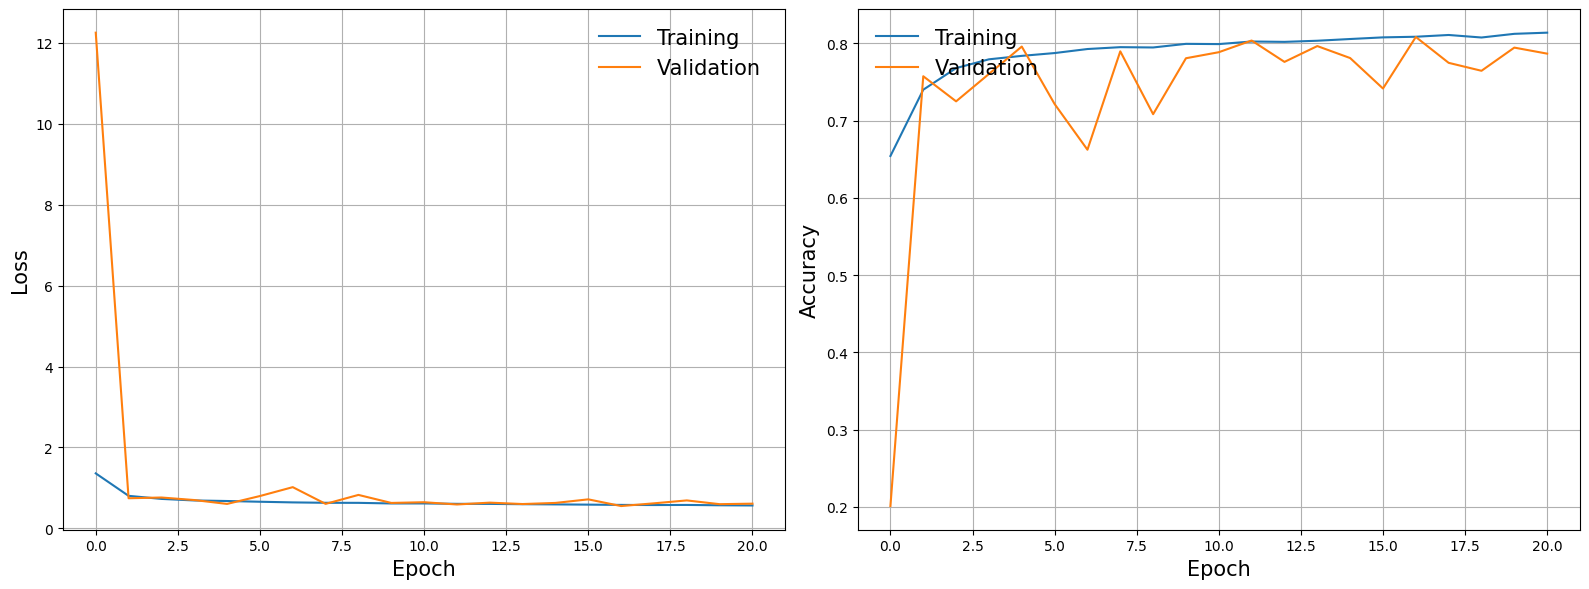

In [25]:
draw_metric_evolution()

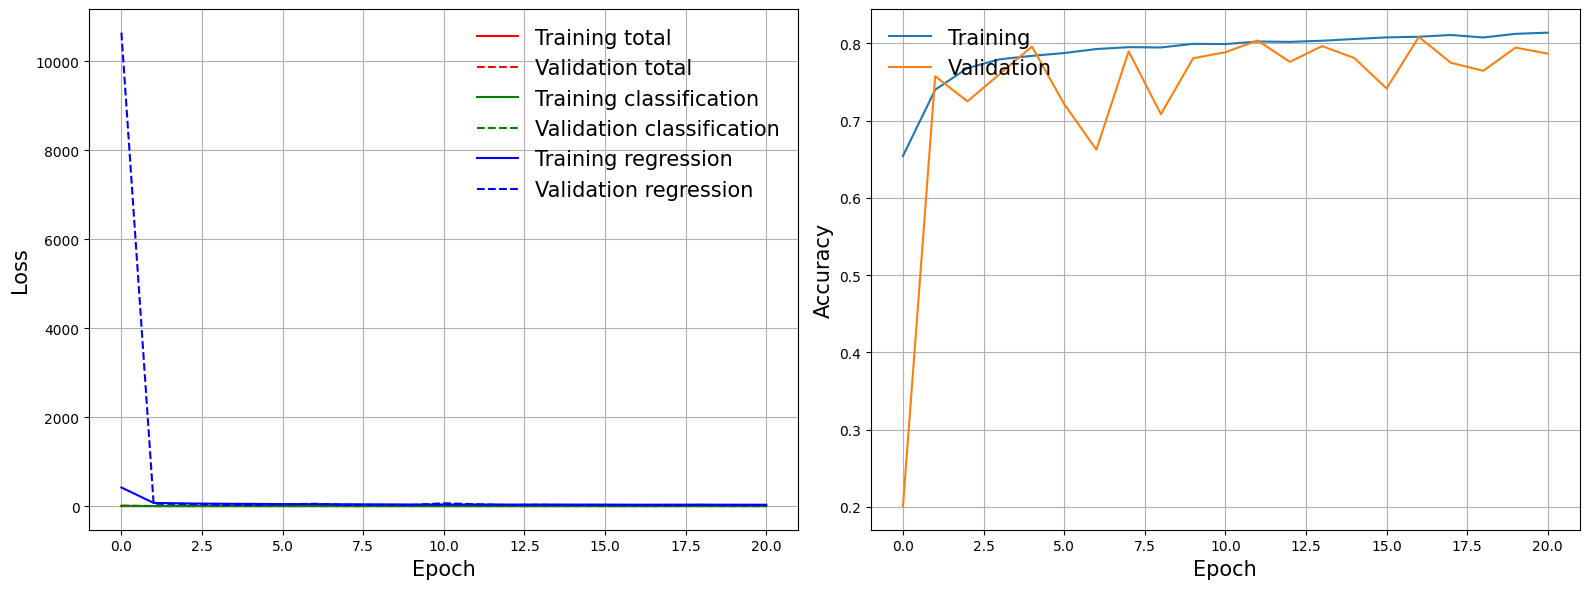

In [26]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(EPOCHS+1))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train,label='Training total', color='red')
  axes.flat[0].plot(epoch_number, loss_val,label='Validation total', color='red', linestyle='dashed')
  axes.flat[0].plot(epoch_number, loss_train_class,label='Training classification', color='green')
  axes.flat[0].plot(epoch_number, loss_val_class,label='Validation classification', color='green', linestyle='dashed')
  axes.flat[0].plot(epoch_number, loss_train_reg,label='Training regression', color='blue')
  axes.flat[0].plot(epoch_number, loss_val_reg,label='Validation regression', color='blue', linestyle='dashed')
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_train,label='Training ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()
draw_metric_evolution()

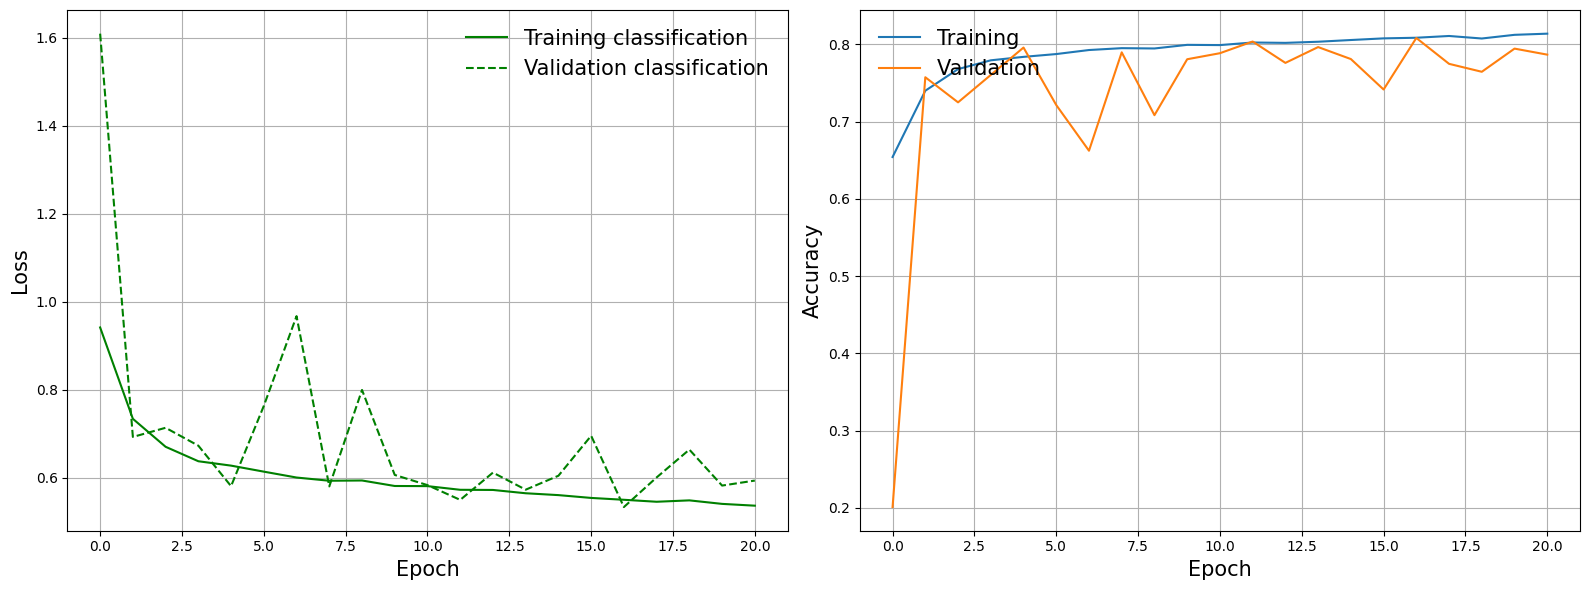

In [27]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(EPOCHS+1))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train_class,label='Training classification', color='green')
  axes.flat[0].plot(epoch_number, loss_val_class,label='Validation classification', color='green', linestyle='dashed')
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_train,label='Training ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()
draw_metric_evolution()

Now let's evaluate how our model performs on the validation dataset by calculating accuracy for each jet type and building the ROC curve.


In [28]:
pred_val = []
pred_label = []
true_label = []
pred_mass = []
true_mass = []
for i, data in enumerate(jets_loader_val):
    inputs, labels, masses = data, data.y[1::2], data.y[::2]
    inputs = inputs.to(device)
    # there is no softmax in the output layer. We have to put it.
    pred_val.append(F.softmax(gnn(inputs.to(device))[:,1:], dim=1).cpu().detach().numpy())
    pred_label.append(np.argmax(pred_val[i],axis=1))
    true_label.append(labels.numpy())
    pred_mass.append(gnn(inputs.to(device))[:,0].cpu().detach().numpy())
    true_mass.append(masses.numpy())
pred_val = np.concatenate(pred_val, axis=0)
pred_label = np.concatenate(pred_label, axis=0)
true_label = np.concatenate(true_label,axis=0)
pred_mass = np.concatenate(pred_mass, axis=0)
true_mass = np.concatenate(true_mass, axis=0)

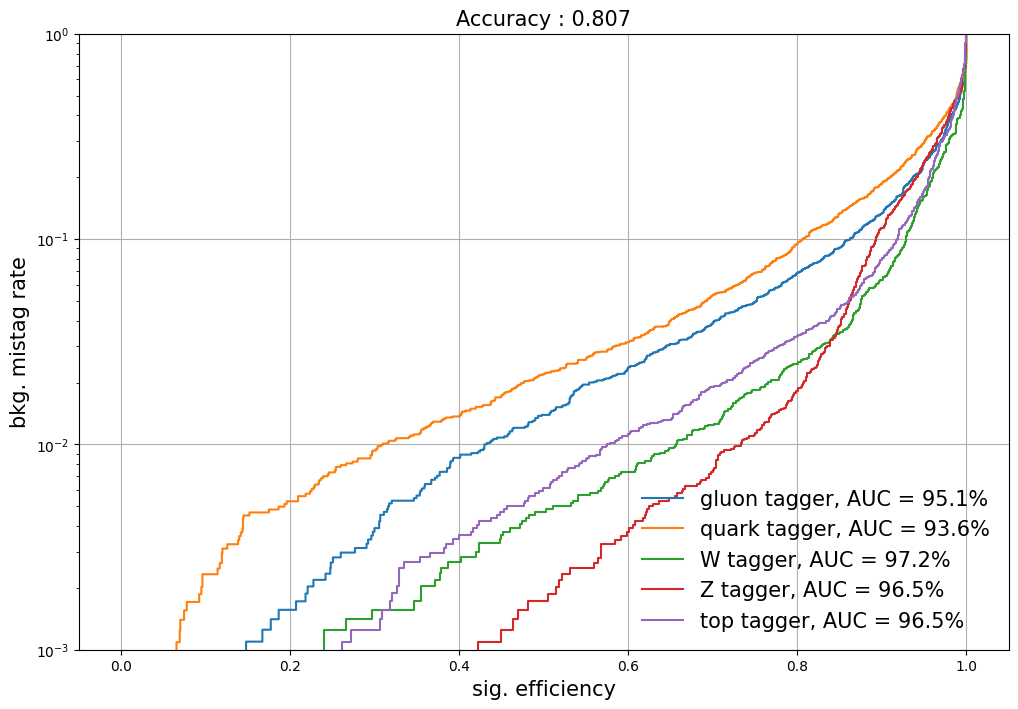

In [29]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#### get the ROC curves
fpr = {}
tpr = {}
auc_value = {}
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    fpr[label], tpr[label], threshold = roc_curve((true_label== i), pred_val[:,i])
    auc_value[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label,auc_value[label]*100.))
#computing accuracy now
acc_score = accuracy_score(true_label, pred_label)
acc_manual = np.sum(pred_label == true_label)
plt.title('Accuracy : {:.3f}'.format(acc_score), fontsize=15)
plt.semilogy()
plt.xlabel("sig. efficiency",fontsize=15)
plt.ylabel("bkg. mistag rate",fontsize=15)
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=15, frameon=False)
plt.show()





Now let's evaluate confusion matrix

In [30]:
# First we define a helper function
import seaborn as sns
sns.set_style("whitegrid")

def plot_matrix(cm, classes, title):
  plt.figure(figsize = (12,12))
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title=title, xlabel="Predicted label", ylabel="True label")

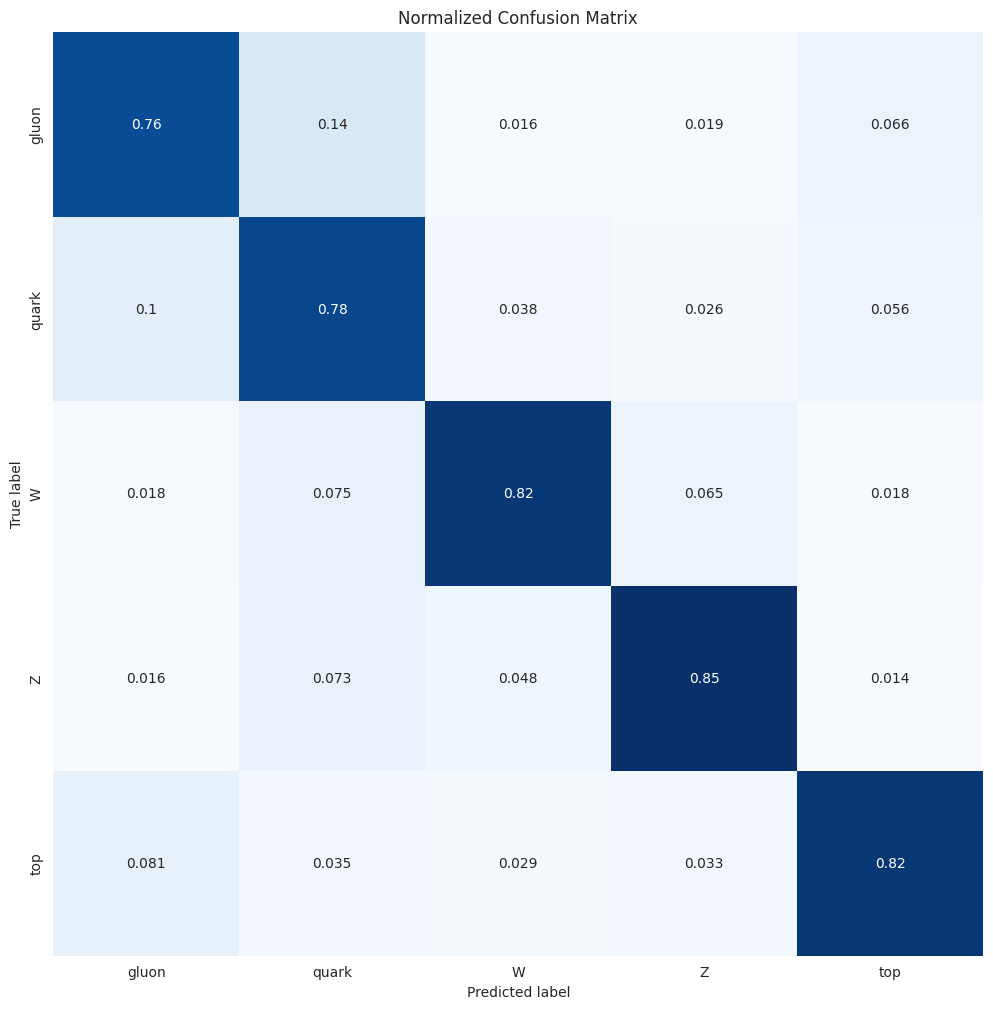

In [31]:
#Evaluate confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_label, pred_label,normalize = 'true')
plot_matrix(cm, label_names, title = 'Normalized Confusion Matrix')

In [32]:
def plot_mass_regression(true_mass, pred_mass, title=None):
    plt.plot(true_mass, pred_mass, 'o')
    plt.xlabel('Target mass (GeV)')
    plt.ylabel('Predicted mass (GeV)')
    x = np.linspace(0, max(max(true_mass),max(pred_mass)), 1000)
    plt.plot(x, x, color='black', linestyle='--')
    if title:
        plt.title(title)
    plt.show()
    print("RMS error:", np.sqrt(((pred_mass-true_mass)**2).mean()))

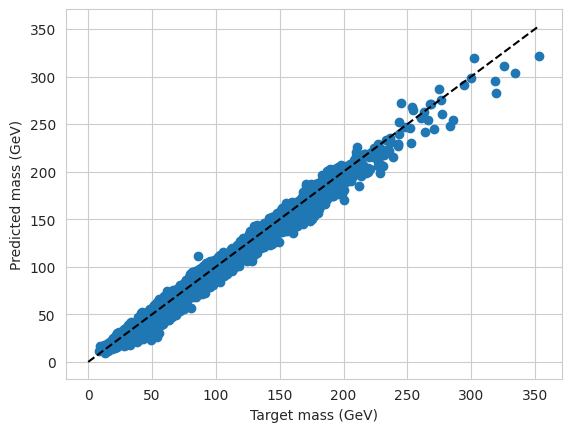

RMS error: 5.8329606


In [33]:
plot_mass_regression(true_mass, pred_mass)

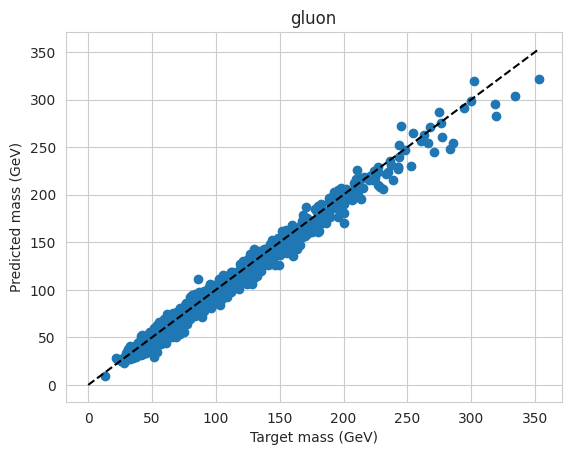

RMS error: 6.4468503


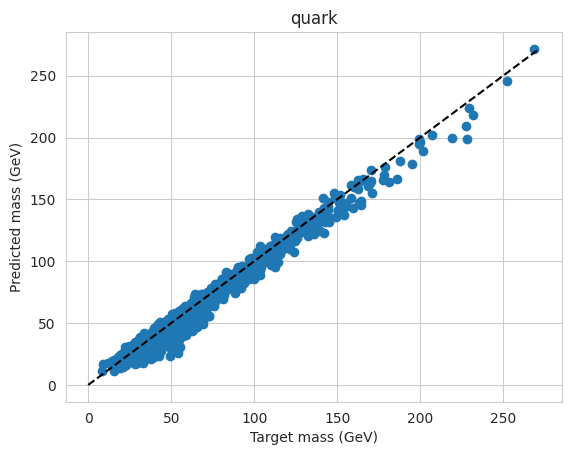

RMS error: 5.715946


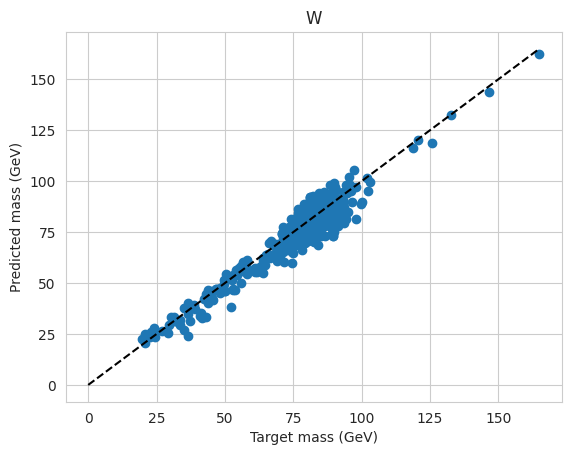

RMS error: 4.0624714


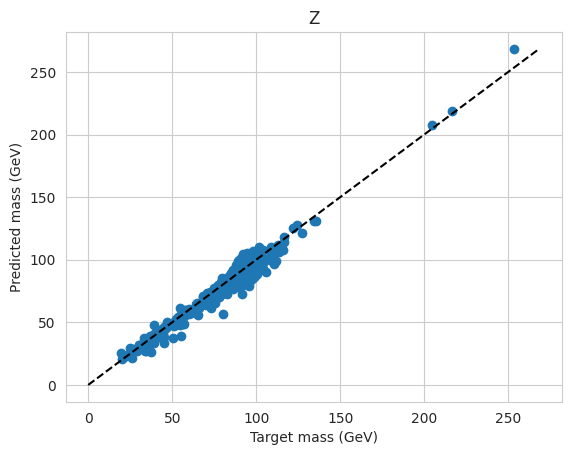

RMS error: 4.4555717


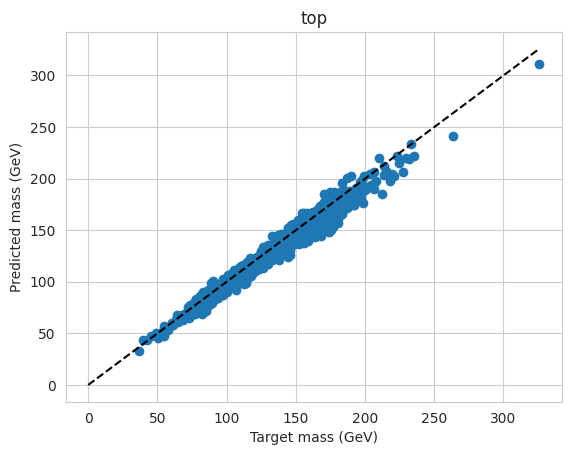

RMS error: 7.711018


In [34]:
for label in np.unique(true_label):
    jet_type_mask = true_label == label
    plot_mass_regression(true_mass[true_label == label], pred_mass[true_label == label], title=label_names[int(label)])